# Joblib Distributed [2/2] - Cluster Mode

This is the second part of the joblib distributed series. We have seen how to use Joblib with Ray, Dask and Spark backends on localhost, but what about parallelizing joblib on a cluster?

Our setup is a JupyterHub deployed on Kubernetes, which spawns Docker containers that host jupyter notebooks. These notebooks can access HDFS files through HiveSQL and run distributed jobs on the Hadoop cluster.

<img src="https://i.imgur.com/SUUj6Yt_d.webp?maxwidth=760&fidelity=grand">

### Requirements

- `scikit-learn >= 0.21.0`
- `joblib`
- `joblib-spark`

### How many cores does my Docker container have?

As we're running a jupyter within a Docker container, we only have access to a fraction of the total physical resources of the underlying Kubernetes cluster. For parallel computing, we're only interested in the available cores:

In [1]:
from joblib import cpu_count

cpu_count()

5

Joblib is designed to avoid oversubscription —the creation of far too many threads compared to the number of cores. It is specialy useful when running estimators in scikit-learn like `RandomForest` or `GridSearch`/`RandomSearch` with `n_jobs=-1`:

In [2]:
from joblib import Parallel

Parallel(backend="loky", n_jobs=-1)._effective_n_jobs()

5

To do so, joblib is [cgroup aware](https://github.com/joblib/joblib/blob/master/joblib/externals/loky/backend/context.py#L124-L125):

In [3]:
!cat /sys/fs/cgroup/cpu/cpu.cfs_quota_us

500000


In [4]:
!cat /sys/fs/cgroup/cpu/cpu.cfs_period_us

100000


The ratio of these two quantities gives the number of cores.

Conversely, packages like `multiprocess` or the Unix command `nproc` are not cgroup aware and return the total number of physical cores, which is wrong and very misleading for our application:

In [5]:
from multiprocessing import cpu_count

cpu_count()

108

In [6]:
!nproc

108


Therefore, we recommend avoiding multiprocessing for this setup.

### How to use joblib-spark?

In [7]:
from joblibspark import register_spark

register_spark()

In [8]:
from joblib import Parallel

Parallel(backend="spark", n_jobs=-1)._effective_n_jobs()

5

### What is my spark config?

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.getConf().get("spark.master")

'yarn'

As opposed to `local[2]` or `local[*]` (2 or * designating the number of cores)

In [10]:
all_confs = sc.getConf().getAll()
[(k, v) for k, v in all_confs if "dynamic" in k]

[('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.dynamicAllocation.initialExecutors', '0'),
 ('spark.dynamicAllocation.maxExecutors', '4'),
 ('spark.dynamicAllocation.enabled', 'true')]

The executors are spawn dynamically (`'spark.dynamicAllocation.enabled', 'true'`), given the available resources and some black magic. This means tasks speed will vary greatly.

In [11]:
sc.getConf().get('spark.executor.cores')

'5'

So, it looks like we're in `dynamicAllocation` mode, which could spawn up to 4 executors of 5 cores each (up to 20 cores).

### Can I change the config on runtime?

Yes pappy! Let's double the resources allocation.

In [12]:
config = sc.getConf()
config.set("spark.dynamicAllocation.maxExecutors", 8) # instead of 4
config.set("spark.executor.cores", 10) # instead of 5
sc.stop()
spark.stop()

spark = SparkSession.builder.config(conf=config).getOrCreate()
sc = spark.sparkContext
sc.getConf().get("spark.dynamicAllocation.maxExecutors")

'8'

In [8]:
Parallel(backend="loky", n_jobs=-1)._effective_n_jobs()

5

In [9]:
Parallel(backend="spark", n_jobs=-1)._effective_n_jobs()

10

### Spark vs Loky for simple functions

In [17]:
import os
from time import time, sleep
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from joblib import Parallel, delayed

def time_sleep(*args):
    sleep(1)
    return (time(), os.getpid())


def compute_intensive(*args):
    total = 0
    for i in range(int(1e7)):
        total += 1
    return (time(), os.getpid())


def plot_pids(out):
    ds, pids = zip(*out)

    ds = np.array(ds)
    ds = ds - ds[0]
    pids = np.array(pids).astype(str)

    print(Counter(Counter(pids).values()))
    
    sns.scatterplot(y=pids, x=ds);
    plt.tight_layout()
    plt.show()

Counter({20: 5})


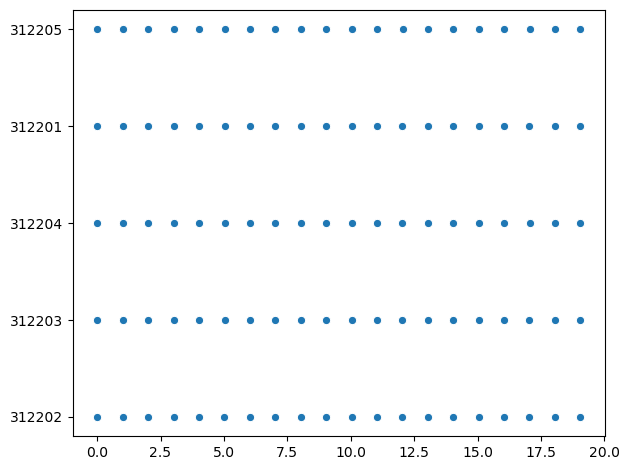

In [154]:
out = Parallel(backend="loky", n_jobs=-1)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

Counter({20: 5})


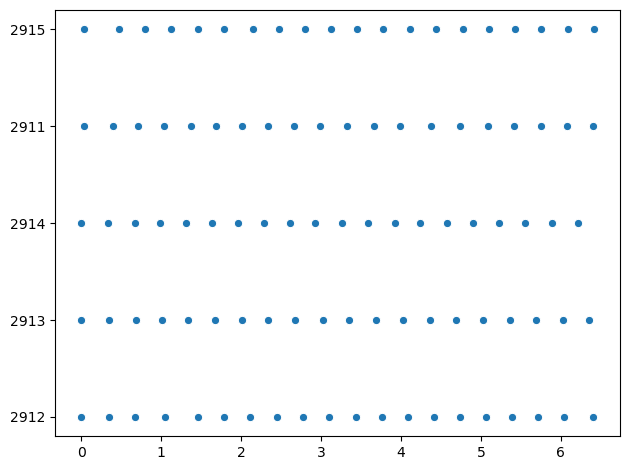

In [25]:
out = Parallel(backend="loky", n_jobs=-1)(
    delayed(compute_intensive)()
    for i in range(100)
)
plot_pids(out)

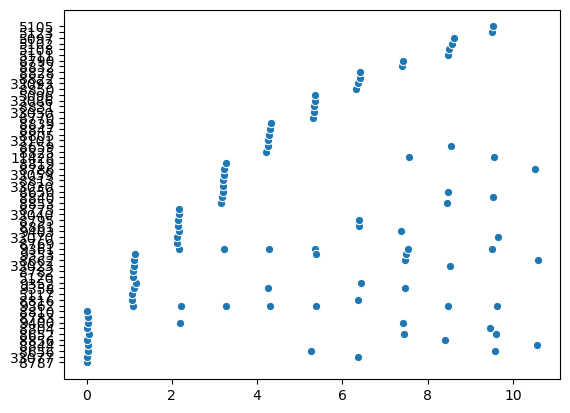

In [106]:
from joblib import Parallel, delayed

out = Parallel(backend="spark", n_jobs=10)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

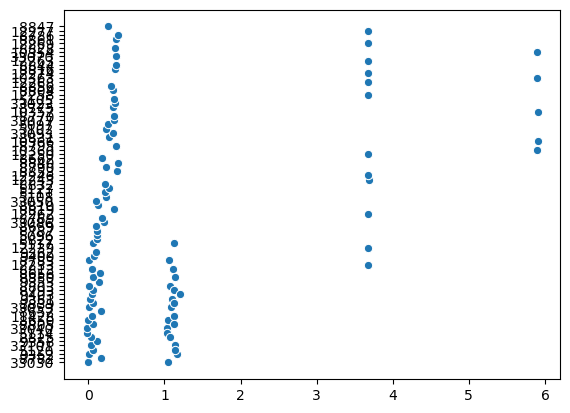

In [107]:
out = Parallel(backend="spark", n_jobs=80)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

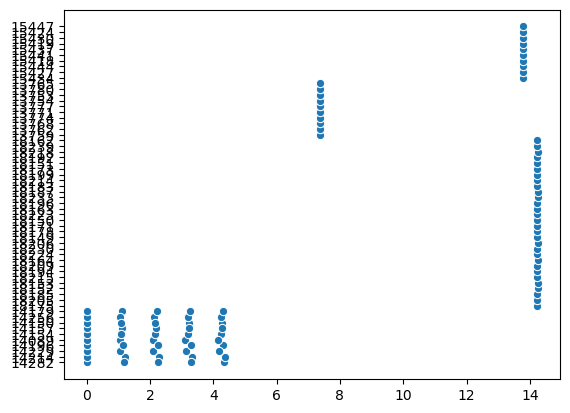

In [110]:
out = Parallel(backend="spark", n_jobs=80)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

Counter({1: 60, 2: 20})


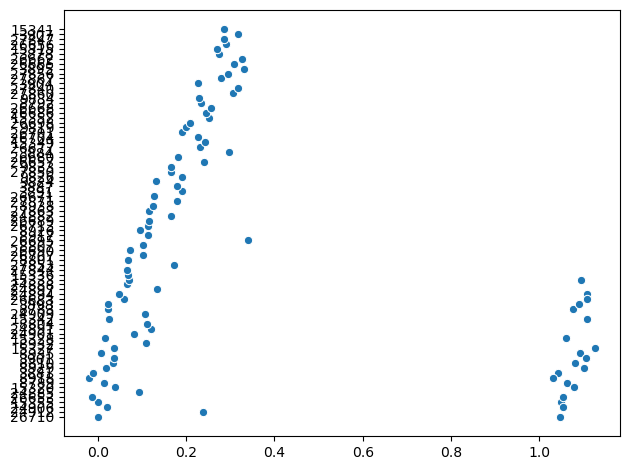

CPU times: user 909 ms, sys: 472 ms, total: 1.38 s
Wall time: 2.75 s


In [152]:
%%time

out = Parallel(backend="spark", n_jobs=80)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

Counter({1: 100})


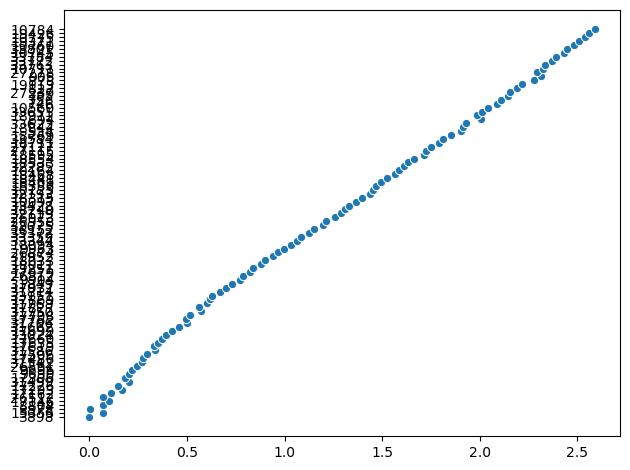

In [153]:
out = sc.parallelize(range(100)).map(time_sleep).collect()
plot_pids(out)

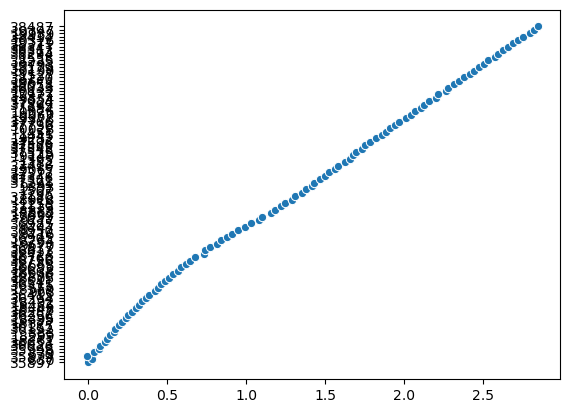

In [131]:
out = sc.parallelize(range(100)).map(time_sleep).collect()
plot_pids(out)

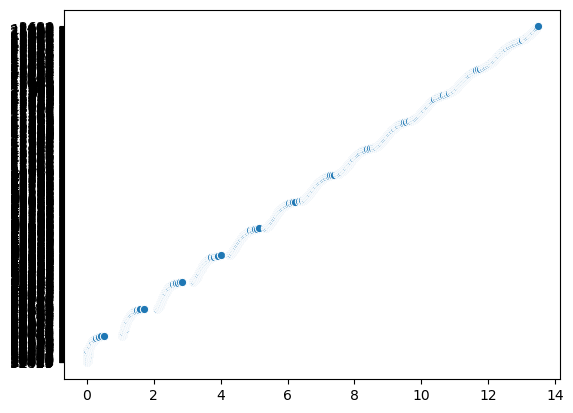

In [132]:
out = sc.parallelize(range(1000)).map(time_sleep).collect()
plot_pids(out)

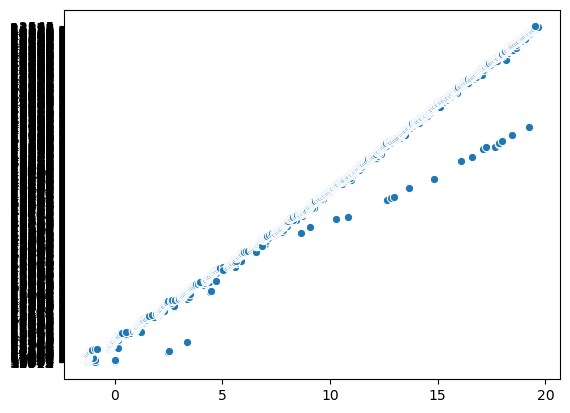

Counter({1: 938, 2: 31})


In [144]:
out = sc.parallelize(range(1000)).map(time_sleep).collect()
plot_pids(out)

### From spark dynamic resource allocation to static 

In [13]:
config = sc.getConf()
config.set("spark.dynamicAllocation.enabled", 'false')  # instead of 'true'
sc.stop()
spark.stop()

spark = SparkSession.builder.config(conf=config).getOrCreate()
sc = spark.sparkContext
sc.getConf().get("spark.dynamicAllocation.enabled")

'false'

In [14]:
Parallel(backend="spark", n_jobs=-1)._effective_n_jobs()

20

Counter({5: 12, 6: 4, 4: 4})


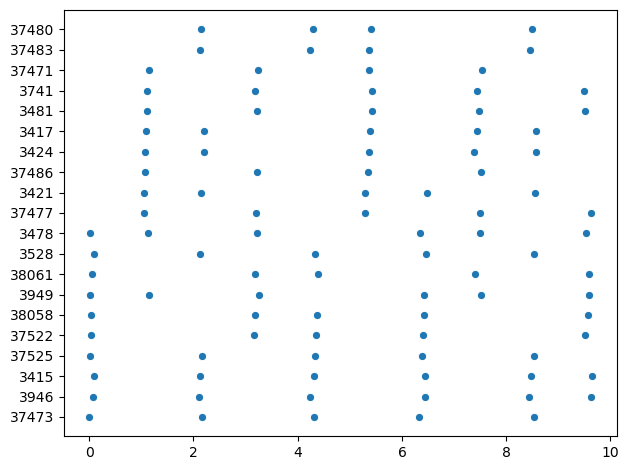

In [20]:
from joblib import Parallel, delayed

out = Parallel(backend="spark", n_jobs=10)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

Counter({5: 20})


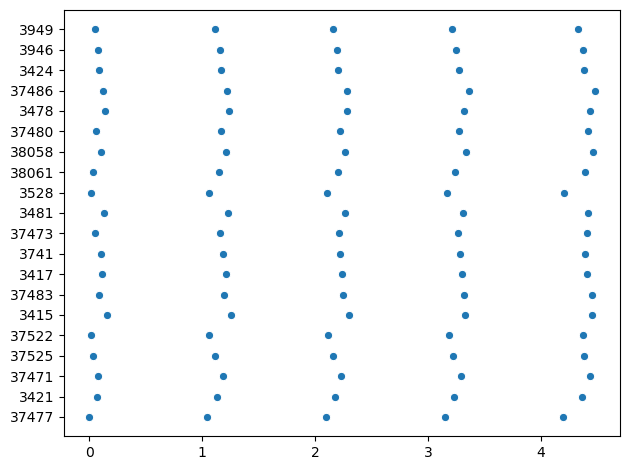

In [22]:
out = Parallel(backend="spark", n_jobs=20)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

/export/home/vmaladiere/.user_conda/envs/conda_vmaladiere/lib/python3.7/site-packages/joblibspark/backend.py:108: UserWarning: User-specified n_jobs (80) is greater than the max number of concurrent tasks (20) this cluster can run now.If dynamic allocation is enabled for the cluster, you might see more executors allocated.
  warnings.warn(f"User-specified n_jobs ({n_jobs}) is greater than the max number of "


Counter({6: 12, 5: 4, 2: 4})


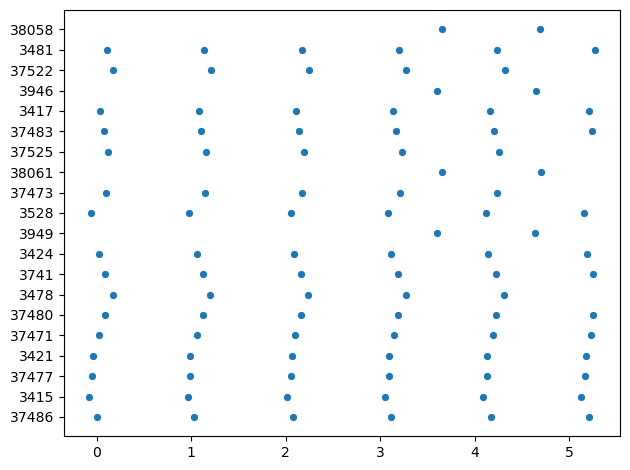

In [19]:
out = Parallel(backend="spark", n_jobs=80)(
    delayed(time_sleep)()
    for i in range(100)
)
plot_pids(out)

Counter({8: 4, 6: 3, 4: 3, 7: 2, 9: 2, 5: 1, 1: 1})


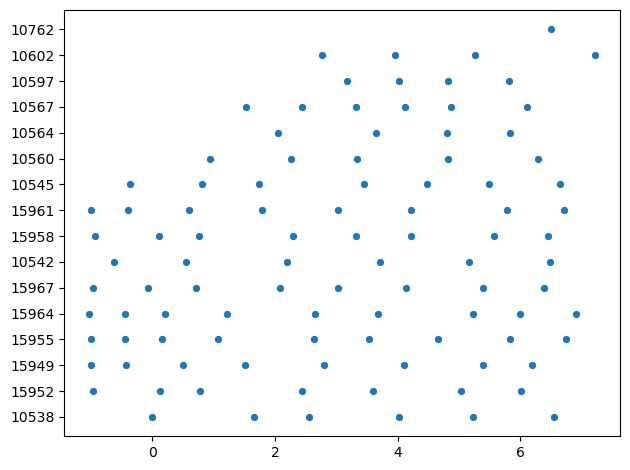

In [26]:
out = Parallel(backend="spark", n_jobs=10)(
    delayed(compute_intensive)()
    for i in range(100)
)
plot_pids(out)

Counter({6: 10, 4: 6, 5: 2, 3: 2})


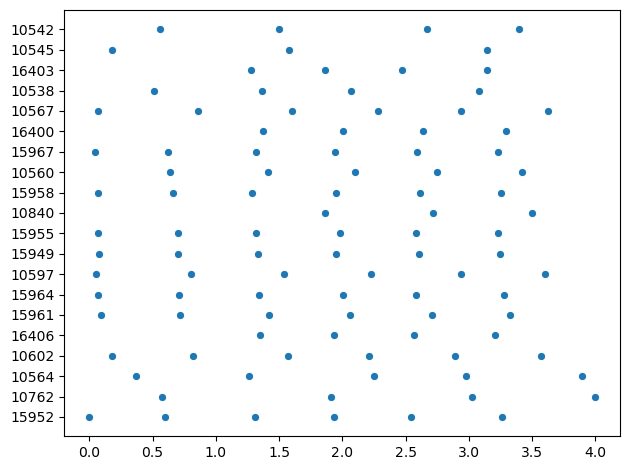

In [27]:
out = Parallel(backend="spark", n_jobs=20)(
    delayed(compute_intensive)()
    for i in range(100)
)
plot_pids(out)

Counter({1: 100})


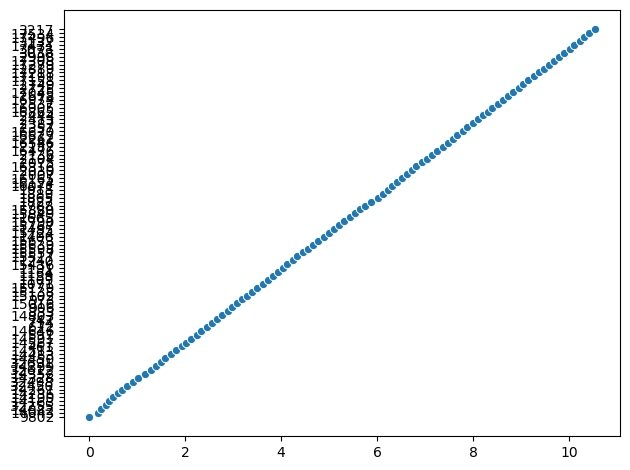

In [20]:
out = sc.parallelize(range(100)).map(time_sleep).collect()
plot_pids(out)

Counter({1: 98, 2: 1})


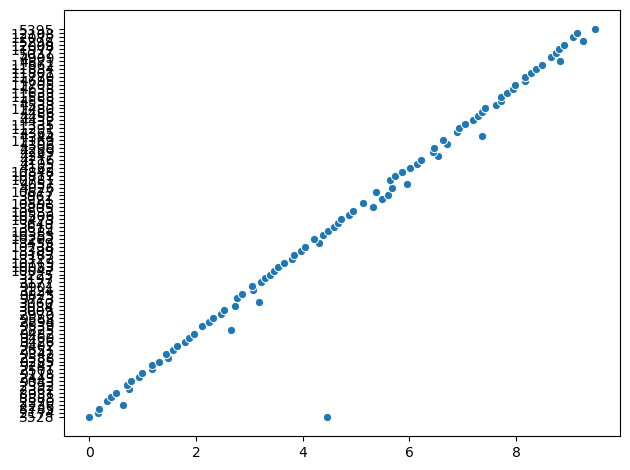

In [24]:
out = sc.parallelize(range(100)).map(compute_intensive).collect()
plot_pids(out)

In [15]:
sorted(sc.getConf().getAll(), key=lambda x: x[0])

[('spark.acls.enable', 'true'),
 ('spark.app.id', 'application_1666100950046_66598'),
 ('spark.app.name', 'JoblibSparkBackend'),
 ('spark.default.parallelism', '2000'),
 ('spark.driver.bindAddress', '0.0.0.0'),
 ('spark.driver.blockManager.port', '21287'),
 ('spark.driver.extraJavaOptions',
  '-Dhdp.version=2.6.5.0-292 -Dhttp.proxyHost=10.143.10.20 -Dhttp.proxyPort=8080 -Dhttps.proxyHost=10.143.10.20 -Dhttps.proxyPort=8080 -Djava.security.auth.login.config=/export/home/vmaladiere/.jaas.conf'),
 ('spark.driver.extraLibraryPath',
  '/usr/hdp/current/hadoop-client/lib/native'),
 ('spark.driver.host', 'spark-client.jupyterhub.eds-int.aphp.fr'),
 ('spark.driver.maxResultSize', '10g'),
 ('spark.driver.memory', '10g'),
 ('spark.driver.memoryOverhead', '200'),
 ('spark.driver.port', '21287'),
 ('spark.dynamicAllocation.enabled', 'false'),
 ('spark.dynamicAllocation.initialExecutors', '0'),
 ('spark.dynamicAllocation.maxExecutors', '8'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.

## Using scikit-learn

In [29]:
from time import time
from joblib import parallel_backend
from scipy.stats import uniform, loguniform

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100)
estimator = HistGradientBoostingClassifier()

param_grid = {
    "learning_rate": loguniform.rvs(.001, .1, size=10),
    "min_samples_leaf": uniform.rvs(20, 50, size=10).astype(int),
    "max_iter": uniform.rvs(5, 30, size=10).astype(int),
}

In [155]:
with parallel_backend(backend="loky"):
    tic = time()
    cv = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose=10).fit(X, y)
    duration_1 = time() - tic
duration_1

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


22.855014324188232

In [32]:
with parallel_backend(backend="spark"):
    tic = time()
    cv = GridSearchCV(estimator, param_grid, n_jobs=20, verbose=10).fit(X, y)
    duration_2 = time() - tic
duration_2

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/export/home/vmaladiere/.user_conda/envs/conda_vmaladiere/lib/python3.7/site-packages/joblibspark/backend.py:94: UserWarning: For spark version < 3, pyspark cancelling job API has bugs, so we could not terminate running spark jobs correctly. See https://issues.apache.org/jira/browse/SPARK-31549 for reference.
  warnings.warn("For spark version < 3, pyspark cancelling job API has bugs, "


KeyboardInterrupt: 

In [ ]:
from itertools import product
from sklearn.model_selection import cross_validate

def grid_search(params):
    estimator = HistGradientBoostingClassifier(**params)
    return cross_validate(estimator, X, y, n_jobs=1)

all_params = product(*param_grid.values())
all_params = [dict(zip(param_grid.keys(), params)) for params in all_params]
tic = time()
out = sc.parallelize(all_params).map(grid_search).collect()
duration_3 = time() - tic
duration_3

## Ray

Unfortunately, initializing ray crashes the notebook.

In [3]:
import ray

In [4]:
ray.__version__

'2.2.0'

In [ ]:
from ray.util.joblib import register_ray

register_ray()

In [ ]:
with parallel_backend(backend="ray"):
    tic = time()
    cv = GridSearchCV(estimator, param_grid, n_jobs=5).fit(X, y)
    duration_5 = time() - tic
duration_5

The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.
2023-02-22 13:06:39,728	WARNING services.py:1743 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.77gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


## Dask

In [15]:
from dask.distributed import Client

client = Client(processes=False)

/export/home/vmaladiere/.user_conda/envs/conda_vmaladiere/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37251 instead
  http_address["port"], self.http_server.port


In [17]:
with parallel_backend(backend="dask"):
    tic = time()
    cv = GridSearchCV(estimator, param_grid, n_jobs=5).fit(X, y)
    duration_6 = time() - tic
duration_6

114.21485805511475

Slightly better than spark.